# Adaptive confidence distributions with scaling model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.linear_model import LinearRegression
from utils import load_data, RegressionModel, train_model, plot_results

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

For this analysis, we use the "small dataset" with 10k samples selected at random from the full 60K DHS dataset. The data we use consists of latent representations of satllite images $X \in \mathbb{R}^{232}$ and corresponding International Wealth Index (IWI) values $y \in \mathbb{R}$ from survey data. For now, we use the same train-test splits for all experiments, but we should evaluate with cross-validation.

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test = load_data()

Unless otherwised specified, we use the same basic regression model.

In [4]:
RegressionModel()

RegressionModel(
  (fc): Sequential(
    (0): Linear(in_features=232, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

# Model training

The helper function `train_model`, that creates and trains a `RegressionModel` using gradient descent, has the main arguments `X_train, X_val, y_train, y_val, loss_fn`. `loss_fn` is supposed to be a function that in addition to returning the loss to minimize should return a dict object with whatever metric you would like to log during training.

## MSE baseline

  5%|▍         | 2255/50000 [00:05<01:48, 438.04it/s]


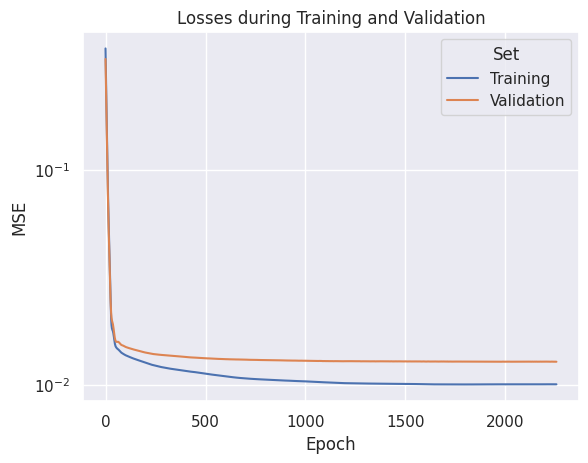

In [5]:
# Example of a loss function that only tracks one metric (MSE)
def mse_loss(pred, target):
    mse = nn.MSELoss()(pred, target)
    return mse, {'MSE': mse.item()}

mse_model = train_model(X_train, X_val, y_train, y_val, lr=1e-3, l2=1e-2, loss_fn=mse_loss, verbose=1)

When we plot the results, we see that the model suffers from attenuation error (the model overestimates wealth for poor places and underestimates for wealthy places).

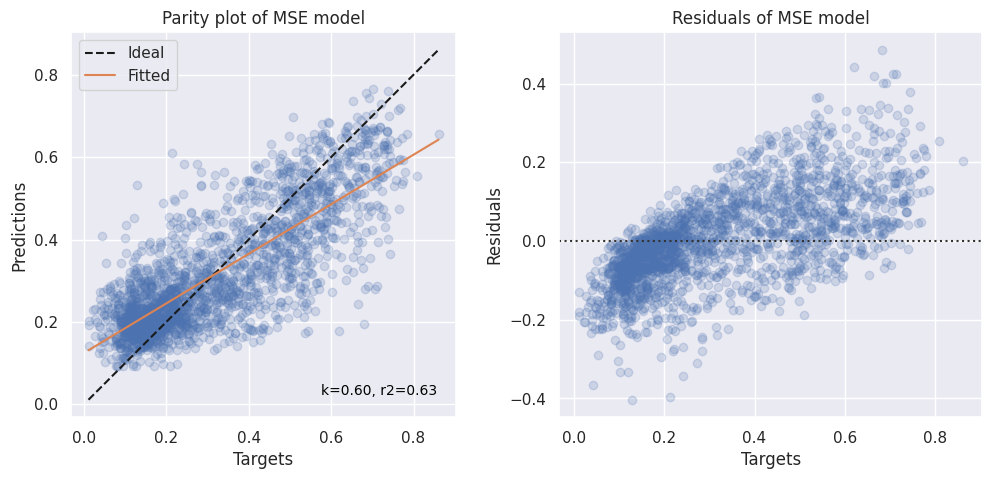

In [6]:
with torch.no_grad():
    y_pred = mse_model(X_test)
    
plot_results(y_test, y_pred, 'MSE model')

One idea is to simply correct for this by fitting a linear regression on the calibration data (should be a separate hold-out set later) and using the coefficients to "correct" the predictions

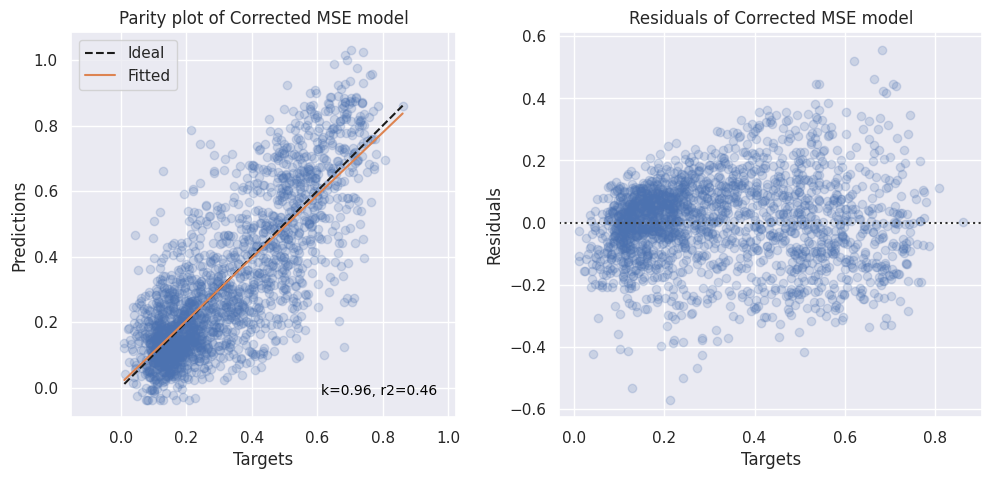

In [7]:
with torch.no_grad():
    y_pred_val = mse_model(X_val)
    slope_model = LinearRegression().fit(y_val.cpu().numpy().reshape(-1, 1), y_pred_val.cpu().numpy())
    
    corrected_y_pred_val = (y_pred_val - slope_model.intercept_) / slope_model.coef_[0]
    corrected_y_pred = (y_pred - slope_model.intercept_) / slope_model.coef_[0]

plot_results(y_test, corrected_y_pred, 'Corrected MSE model')

Instead of using the raw residuals from the calibration set directly, estimate a model for the residual spread based on $X$. That is, define a scaling function $s(X)$ that estimates the local variability of residuals for different values of $X$. A common choice is to fit a separate regression model $g(X)$ to predict the absolute residuals:

$$
s(X)=\mathbb{E}[|Y-\tilde{Y}| \mid X]
$$


We can estimate $s(X)$ by fitting a nonparametric model (e.g., a Gaussian process or a neural network) or simply using a local quantile regression.

Then, modify our estimated confidence distribution as:

$$
\operatorname{CDF}_i(y)=\frac{\left|\left\{j \in\left\{1, \ldots, n_{\text {cal }}\right\} \left\lvert\, r_j \leq \frac{y-\bar{Y}_i}{s\left(X_i\right)}\right.\right\}\right|+1}{n_{\text {cal }}+1}
$$


By dividing the residuals by the estimated uncertainty $s\left(X_i\right)$, we allow the confidence distribution to adapt to the expected variance for different inputs.

In [8]:
with torch.no_grad():
    y_pred_test = mse_model(X_test)
    y_pred_val = mse_model(X_val)
    y_pred_train = mse_model(X_train)
    
    slope_model = LinearRegression().fit(y_val.cpu().numpy().reshape(-1, 1), y_pred_val.cpu().numpy())
    
    corrected_y_pred_test = (y_pred_test - slope_model.intercept_) / slope_model.coef_[0]
    corrected_y_pred_val = (y_pred_val - slope_model.intercept_) / slope_model.coef_[0]
    corrected_y_pred_train = (y_pred_train - slope_model.intercept_) / slope_model.coef_[0]
    
    res_test = (y_test - corrected_y_pred_test)
    res_val = (y_val - corrected_y_pred_val)
    res_train = (y_train - corrected_y_pred_train)
    
    abs_res_test = torch.abs(res_test)
    abs_res_val = torch.abs(res_val)
    abs_res_train = torch.abs(res_train)

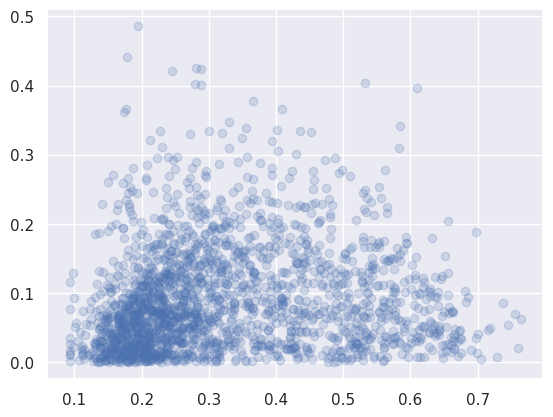

In [9]:
import matplotlib.pyplot as plt

plt.scatter(y_pred_test.cpu().numpy(), torch.abs(y_test - y_pred_test).cpu().numpy(), alpha=0.2)

  0%|          | 243/50000 [00:00<01:36, 516.21it/s]
/cephyr/users/markpett/Alvis/ImputeAwareATE/model_training_experiments/utils.py:233: RuntimeWarning: invalid value encountered in log
  log_pred = np.log(log_model.predict(x_values))  # Convert back to original scale


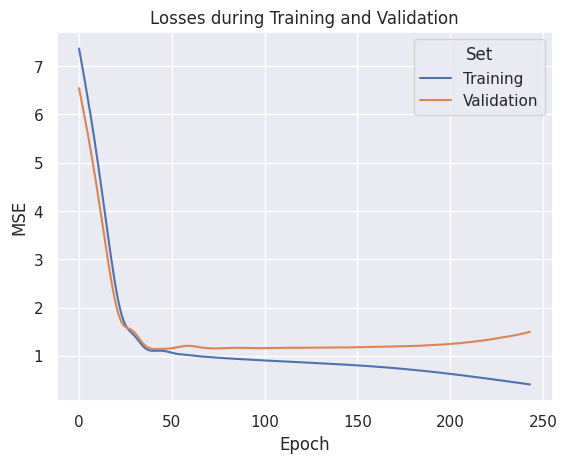

In [14]:
scaling_model = train_model(X_train, X_val, torch.log(abs_res_train), torch.log(abs_res_val), model_size='M', lr=1e-3, l2=1e-3, loss_fn=mse_loss, verbose=1)

In [11]:
abs_res_train

tensor([0.0162, 0.1240, 0.0967,  ..., 0.0247, 0.0895, 0.0192], device='cuda:0')

In [37]:
'''from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train.cpu().numpy(), abs_res_train.cpu().numpy())
print(regr.predict(X_test.cpu().numpy()))

regr.score(X_test.cpu().numpy(), abs_res_test.cpu().numpy())'''

0.03506534797807648

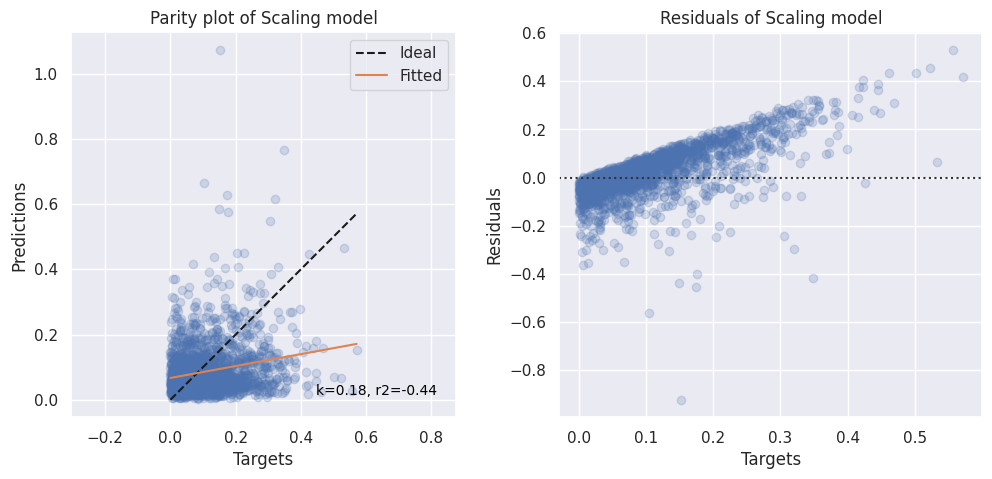

In [15]:
with torch.no_grad():
    abs_res_pred = torch.exp(scaling_model(X_test))
    
plot_results(abs_res_test, abs_res_pred, 'Scaling model')

In [23]:
with torch.no_grad():
    s_test = scaling_model(X_test).cpu().numpy()
    s_val = scaling_model(X_val).cpu().numpy()
    s_train = scaling_model(X_train).cpu().numpy()
    
    res_test = res_test.cpu().numpy()
    res_val = res_val.cpu().numpy()
    res_train = res_train.cpu().numpy()
    
    abs_res_test = abs_res_test.cpu().numpy()
    abs_res_val = abs_res_val.cpu().numpy()
    abs_res_train = abs_res_train.cpu().numpy()

In [30]:
scaled_res_test = res_test / s_test

In [32]:
y_val = y_val.cpu().numpy()

In [29]:
cdf_vals = np.array([
    (np.sum(scaled_residuals <= (y_i - y_pred_new) / s_x_new) + 1) / (len(y_val) + 1)
    for y_i in y_val
])

[ 0.15003812 -0.3020583   0.16285953 ...  0.05489992  0.00537198
 -0.02336837]
[0.08774242 0.107608   0.08775359 ... 0.08773227 0.08773224 0.08774093]
[ 1.709984   -2.8070247   1.855873   ...  0.6257666   0.06123154
 -0.2663338 ]


In [36]:
import numpy as np

def compute_adaptive_cdf(scale_cal, scale_test, y_cal, y_pred_cal, y_pred_test):
    """
    Computes an adaptive confidence distribution for test points using conformal prediction with scaled residuals.

    Parameters:
    - scaling_model: A trained model that predicts the residual scale given X.
    - X_cal: Calibration feature matrix (n_cal, d).
    - y_cal: Calibration target values (n_cal,).
    - y_pred_cal: Predicted values on the calibration set (n_cal,).
    - X_test: Test feature matrix (n_test, d).
    - y_pred_test: Predicted values on the test set (n_test,).

    Returns:
    - cdf_list: A list of functions where each function represents the empirical CDF for a test point.
    """
    
    # Step 1: Compute residuals on calibration set
    residuals_cal = y_cal - y_pred_cal

    # Step 3: Normalize residuals
    scaled_residuals = residuals_cal / scale_cal

    # Step 4: Compute empirical CDFs for each test instance
    n_cal = len(y_cal)
    sorted_scaled_residuals = np.sort(scaled_residuals)  # Sort for CDF computation

    def empirical_cdf(y, y_pred, scale):
        """
        Computes the empirical CDF for a given y value, test prediction, and scale.
        """
        adjusted_y = (y - y_pred) / scale  # Normalize test residual
        rank = np.searchsorted(sorted_scaled_residuals, adjusted_y, side='right')
        return (rank + 1) / (n_cal + 1)
    
    
    
    

    # Create a list of CDF functions for each test instance
    cdf_list = [
        lambda y, y_pred=y_pred_test[i], scale=scale_test[i]: empirical_cdf(y, y_pred, scale)
        for i in range(len(y_pred_test))
    ]

    return cdf_list

#print('s_val', s_val, '\n', 's_test', s_test, '\n', 'y_val', y_val, '\n', 'corrected_y_pred_val', corrected_y_pred_val, '\n', 'corrected_y_pred_test', corrected_y_pred_test, '\n')
cdfs = compute_adaptive_cdf(s_val, s_test, y_val, corrected_y_pred_val.cpu().numpy(), corrected_y_pred_test.cpu().numpy())

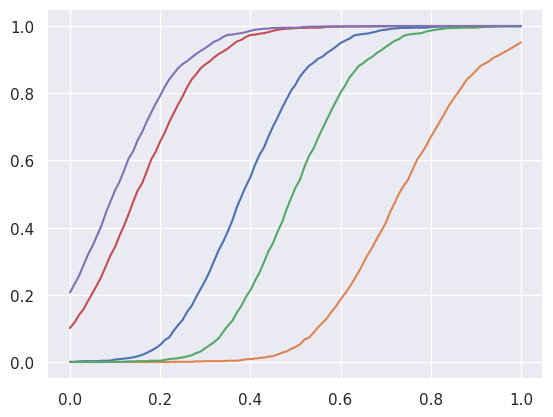

In [47]:
import matplotlib.pyplot as plt

i = 0

for i in range(5):
    percs = []
    ys = np.linspace(0, 1, 101)
    for y_i in ys:
        percs.append(cdfs[i](y_i))

    plt.plot(ys, percs)
    
plt.show()

In [ ]:
ys = np.linspace(0, 1, 101)
for y_i in ys:
    